# Gene Expression Analysis

Lorem ipsum...

In [13]:
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from scipy.stats import ttest_rel
from tqdm import tqdm

from philharmonic.utils import (
    load_cluster_json,
    parse_GO_database,
    plot_cluster,
    print_cluster,
)

In [14]:
# Initial Files
cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.functional.json"
network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_network.positive.tsv"
go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_GO_map.csv"

GO_DB = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/go.obo"

# Gene Expression Datas
expression_file_path = "/mnt/home/ssledzieski/database/philharmonic/p_damicornis/Connelly2022_AxH_Pdam.counts"
deg_file_path = "/mnt/home/ssledzieski/database/philharmonic/p_damicornis/Connelly2022_SupplementaryData.xlsx"

# Output paths
prot_deg_cytoscape_table = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_proteins.deg.tsv"
clust_deg_cytoscape_table = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.deg.tsv"

from pathlib import Path
IMG_DIR = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/img")

---

## Load Files

In [15]:
cluster_dict = load_cluster_json(cluster_file_path)
go_database = parse_GO_database(GO_DB)
full_G = nx.read_weighted_edgelist(network_file_path, delimiter="\t")

In [16]:
deg_df = pd.read_excel(
    deg_file_path,
    sheet_name="Table_S4A_DEGs_coral",
    header=1,
    index_col=0,
).rename(
    {
        "DE_Heat": "DE_Heat_control",
        "DE_Antibiotics": "DE_Antibiotics_control",
        "DE_Antibiotics.Heat": "DE_Antibiotics.Heat_control",
    },
    axis=1,
)
deg_df.index = deg_df.index + "-RA"

In [17]:
expression_df = pd.read_csv(expression_file_path, sep="\t", skiprows=1)
expression_df.columns = [i.split("/")[-1].split("_")[0] for i in expression_df.columns]
expression_df["Geneid"] = expression_df["Geneid"] + "-RA"
expression_df = expression_df.set_index("Geneid")
expression_df = expression_df.iloc[:, 5:]

---

## Raw Expression

In [161]:
philharmonic_proteins = set.union(*[set(i["members"] + list(i["recipe"]["degree"]["0.75"])) for i in cluster_dict.values()])
expression_philharmonic = expression_df.loc[
    expression_df.index.intersection(philharmonic_proteins)
]

In [162]:
logger.info(f"Expression data has shape: {expression_philharmonic.shape}")
expression_philharmonic.head()

2024-10-04 14:41:40.705 | INFO     | __main__:<module>:1 - Expression data has shape: (7242, 47)


,Hw1-1a,Hw1-1b,Hw1-1c,Hw1-4a,Hw1-4b,Hw1-4c,Hw1-5a,Hw1-5b,Hw1-5c,Hw1-6a,...,Wt2-1c,Wt2-4a,Wt2-4b,Wt2-4c,Wt2-5a,Wt2-5b,Wt2-5c,Wt2-6a,Wt2-6b,Wt2-6c
Geneid,,,,,,,,,,,,,,,,,,,,,
pdam_00021773-RA,292,72,77,26,8,37,353,51,271,380,...,6,5,34,16,30,23,2,28,13,25
pdam_00022011-RA,1,10,6,8,15,7,17,27,10,18,...,17,23,74,101,47,31,39,67,74,79
pdam_00012251-RA,925,1950,1260,624,1104,1154,2973,1975,1960,2170,...,1215,1117,1905,1670,1574,1933,1502,1813,1460,1686
pdam_00012254-RA,110,278,197,159,164,253,362,523,424,356,...,370,334,618,514,577,550,353,715,347,502
pdam_00012261-RA,5,7,26,30,26,14,68,103,50,46,...,104,30,188,279,156,203,100,273,246,185


Following Connelly et al., we apply a variance-stabilizing transformation to expression counts, then compute the pairwise bi-weighted mid-correlation between genes.

In [163]:
def vst(counts, alpha=1):
    """
    Apply a variance stabilizing transformation to count data.

    Parameters:
    counts (array-like): The input count data
    alpha (float): A small constant to avoid taking log of zero

    Returns:
    numpy.ndarray: The transformed data
    """
    counts = np.asarray(counts)
    return np.log2(counts + np.sqrt(counts + alpha**2))


def bicor_matrix(X, epsilon=1e-12):
    """
    Compute pairwise bi-weight mid-correlation for all genes.

    Parameters:
    X (np.ndarray): A 2D array of shape (n_genes, n_samples) containing normalized count data
    epsilon (float): Small value to avoid division by zero

    Returns:
    np.ndarray: A 2D array of shape (n_genes, n_genes) containing pairwise correlations
    """
    # Compute median and MAD for each gene
    gene_medians = np.median(X, axis=1)
    gene_mads = np.median(np.abs(X - gene_medians[:, np.newaxis]), axis=1)

    # Handle genes with zero MAD
    gene_mads = np.maximum(gene_mads, epsilon)

    # Compute U matrix
    U = (X - gene_medians[:, np.newaxis]) / (9 * gene_mads[:, np.newaxis])

    # Compute weights
    W = (1 - U**2) ** 2
    W[np.abs(U) >= 1] = 0

    # Compute weighted centered expression
    X_weighted = W * (X - gene_medians[:, np.newaxis])

    # Compute pairwise correlations
    norms = np.sqrt(np.sum(X_weighted**2, axis=1))
    norms = np.maximum(norms, epsilon)  # Avoid division by zero
    corr_matrix = np.dot(X_weighted, X_weighted.T) / np.outer(norms, norms)

    # Set diagonal to 1 and handle numerical instability
    np.fill_diagonal(corr_matrix, 1)
    corr_matrix = np.clip(corr_matrix, -1, 1)

    return corr_matrix

In [164]:
dense_df = expression_df[np.sum(expression_df > 0,axis=1) > expression_df.shape[1] * 0.5]
dense_corr = bicor_matrix(vst(dense_df.values))
dense_corr_df = pd.DataFrame(
    dense_corr,
    index=dense_df.index,
    columns=dense_df.index,
)
expression_df.shape, dense_corr_df.shape

((26077, 47), (20496, 20496))

In [165]:
cluster_proteins = set.union(*[set(i["members"]) for i in cluster_dict.values()])
removed_proteins = set(expression_df.index).difference(dense_corr_df.index)
removed_cluster_proteins = cluster_proteins.intersection(removed_proteins)
logger.info(f"Removed {len(removed_proteins)} proteins from the expression data, {len(removed_cluster_proteins)} which were in clusters.")

2024-10-04 14:41:50.354 | INFO     | __main__:<module>:4 - Removed 5581 proteins from the expression data, 796 which were in clusters.


In [166]:
def extract_cluster_correlations(cluster_members, correlation_df, summary_func=None):
    """
    Extract the lower diagonal of pairwise correlations for a set of genes.

    Parameters:
    cluster_members (list): A list of gene names
    correlation_df (pd.DataFrame): A DataFrame containing pairwise correlations

    Returns:
    pd.DataFrame: A DataFrame containing pairwise correlations for the input genes
    """
    members = list(set(cluster_members).intersection(correlation_df.index))
    cluster_correlations = correlation_df.loc[members, members].values[
        np.tril_indices(len(members), k=-1)
    ]
    if summary_func:
        return summary_func(cluster_correlations)
    else:
        return cluster_correlations


def resample_correlation_matrix(correlation_df, random_seed=42):
    """
    Randomly re-order the row and column names and reassign them to a correlation matrix.
    """
    from copy import deepcopy

    new_df = deepcopy(correlation_df)
    rng = np.random.default_rng(random_seed)
    new_prot_order = rng.permutation(new_df.index)
    new_df.index = new_prot_order
    new_df.columns = new_prot_order
    return new_df

In [167]:
rand_correlation_df = resample_correlation_matrix(dense_corr_df)

cluster_corr_df = pd.DataFrame(
    {
        "key": cluster_dict.keys(),
        "True": [
            extract_cluster_correlations(c["members"] + list(c["recipe"]["degree"]["0.75"]), dense_corr_df, np.median)
            for c in cluster_dict.values()
        ],
        "Randomized": [
            extract_cluster_correlations(c["members"] + list(c["recipe"]["degree"]["0.75"]), rand_correlation_df, np.median)
            for c in cluster_dict.values()
        ],
    }
)

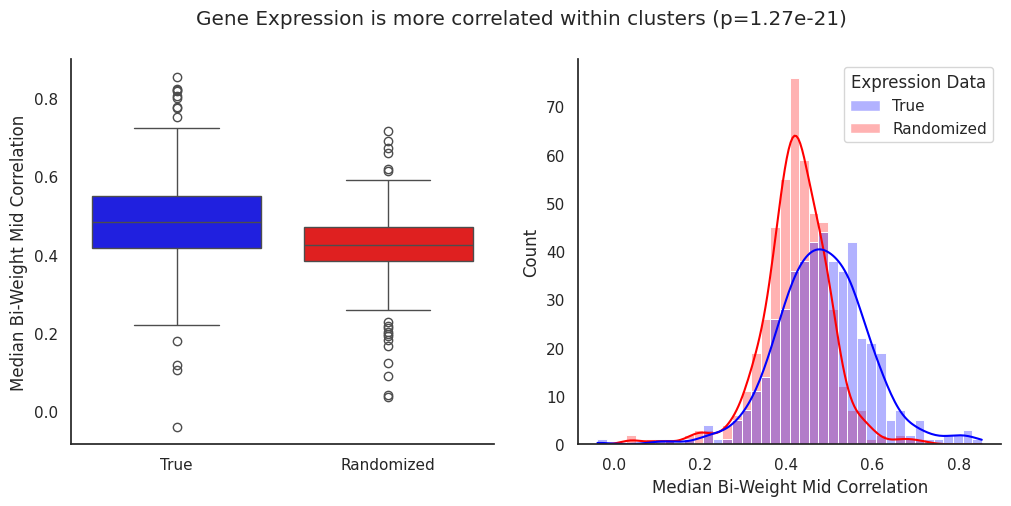

In [171]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.set_theme(style="white", palette="pastel", font_scale=1)

sns.boxplot(cluster_corr_df, palette=["blue", "red"], ax=ax[0]).set(
    ylabel="Median Bi-Weight Mid Correlation"
)
tstat, p = ttest_rel(
    cluster_corr_df["True"], cluster_corr_df["Randomized"], alternative="greater"
)

plot_df = cluster_corr_df.melt("key").rename(
    {"value": "Median Bi-Weight Mid Correlation", "variable": "Expression Data"}, axis=1
)
sns.histplot(
    data=plot_df,
    x="Median Bi-Weight Mid Correlation",
    hue="Expression Data",
    alpha=0.3,
    kde=True,
    palette=["blue", "red"],
    common_norm=False,
    ec="white",
    ax=ax[1],
)

plt.suptitle(f"Gene Expression is more correlated within clusters (p={p:.2e})")
sns.despine()

plt.savefig("../img/readme_expression_correlation.png", bbox_inches="tight", dpi=300)
plt.savefig(IMG_DIR / "gexp_enrichment.svg", bbox_inches="tight", dpi=300)
plt.show()

---

## Investigate Differentially Expressed Genes

In [130]:
deg_df.head()

,log2FoldChange_Heat_control,log2FoldChange_Antibiotics_control,log2FoldChange_Antibiotics.Heat_control,padj_Heat_control,padj_Antibiotics_control,padj_Antibiotics.Heat_control,DE_Heat_control,DE_Antibiotics_control,DE_Antibiotics.Heat_control,Gene_Name,Gene_Info,GO_Terms_IPS,GO_Terms_EM,KO_Terms_KAAS,KO_Terms_EM,KOG_Class_A,KOG_Class,Pfam_Domains
ID,,,,,,,,,,,,,,,,,,
pdam_00000001-RA,0.279896,0.067268,-0.254156,0.470404,0.896316,0.368372,NaN,NaN,NaN,NaN,unknown function,"GO:0005515, GO:0007165",NaN,NaN,NaN,NaN,NaN,PF00531
pdam_00000002-RA,-0.080965,-0.383006,-0.774704,0.850611,0.217305,0.000749,NaN,NaN,Downregulated,NaN,Uncharacterized 41.2 kDa protein in cps regio...,NaN,NaN,NaN,NaN,NaN,NaN,"PF00534, PF16095"
pdam_00000003-RA,0.209604,-0.319891,-0.669069,0.682981,0.501258,0.033824,NaN,NaN,Downregulated,NaN,unknown function,NaN,NaN,NaN,NaN,NaN,NaN,PF16095
pdam_00000006-RA,-0.090214,-0.379147,-0.613997,0.783354,0.116652,0.001072,NaN,NaN,Downregulated,NaN,unknown function,GO:0005515,NaN,NaN,NaN,NaN,NaN,PF13424
pdam_00000007-RA,-0.147869,-0.063538,-0.355971,0.609879,0.851811,0.052537,NaN,NaN,NaN,NaN,KLC1: Kinesin light chain 1 (Homo sapiens),GO:0005515,NaN,NaN,NaN,NaN,NaN,PF13424


In [131]:
connelly_hubs = [
    f"pdam_{p}-RA"
    for p in [
        "00016931",  # Blue
        "00015892",  # Dark green
        "00006619",  # Palevioletred3 (found) (antibiotics.heat up) immune response, response to virus, morphogenesis, catabolic process, ubiquitination
        "00012426",  # Lightsteelblue1
        "00024070",  # Orange
        "00014622",  # Royalblue
        "00010339",  # Bisque4
        "00002241",  # Floralwhite
        "00015203",  # Skyblue (found)  (antibiotics.heat down) receptor signaling pathway, nervous system development, exocytosis, vesicles, development
        "00002625",  # Cyan (found) (control up, heat up, antibiotics.heat down) many neural things --> related to the coral "brain"?
        "00009922",  # Grey60
        "00020781",  # Mediumpurple3 (found) (control up) signal transduction mechanisms, regulation of epithelial immune processes --> innate immune response, response to drugs
    ]
]

In [157]:
from philharmonic.utils import hash_cluster

p = connelly_hubs[11]  # 2, 8, 9, 11
c = [v for v in cluster_dict.values() if p in v["members"]]
if len(c):
    c = c[0]
    logger.info(f"Loading cluster {hash_cluster(c['members'])} for protein {p}")
else:
    logger.error(f"Protein {p} not found in any cluster")
    c = None

2024-10-04 11:13:27.032 | INFO     | __main__:<module>:7 - Loading cluster 1575511308955286673 for protein pdam_00020781-RA


2024-10-04 11:13:27.223 | INFO     | __main__:<module>:1 - Cluster of 27 proteins [pdam_00000875-RA, pdam_00012756-RA, pdam_00004148-RA, ...] (hash 1575511308955286673)
0 proteins re-added by ReCIPE (degree, 0.75)
Edges: 25
Triangles: 0
Max Degree: 23
Top Terms:
		GO:0006260 - <DNA replication> (4)
		GO:0045087 - <innate immune response> (4)
		GO:0006915 - <apoptotic process> (4)
		GO:0006888 - <endoplasmic reticulum to Golgi vesicle-mediated transport> (4)
		GO:0035023 - <regulation of Rho protein signal transduction> (4)
		GO:0042220 - <response to cocaine> (3)
		GO:0060316 - <positive regulation of ryanodine-sensitive calcium-release channel activity> (3)
		GO:0043278 - <response to morphine> (3)
		GO:0043029 - <T cell homeostasis> (3)
		GO:0009245 - <lipid A biosynthetic process> (3)



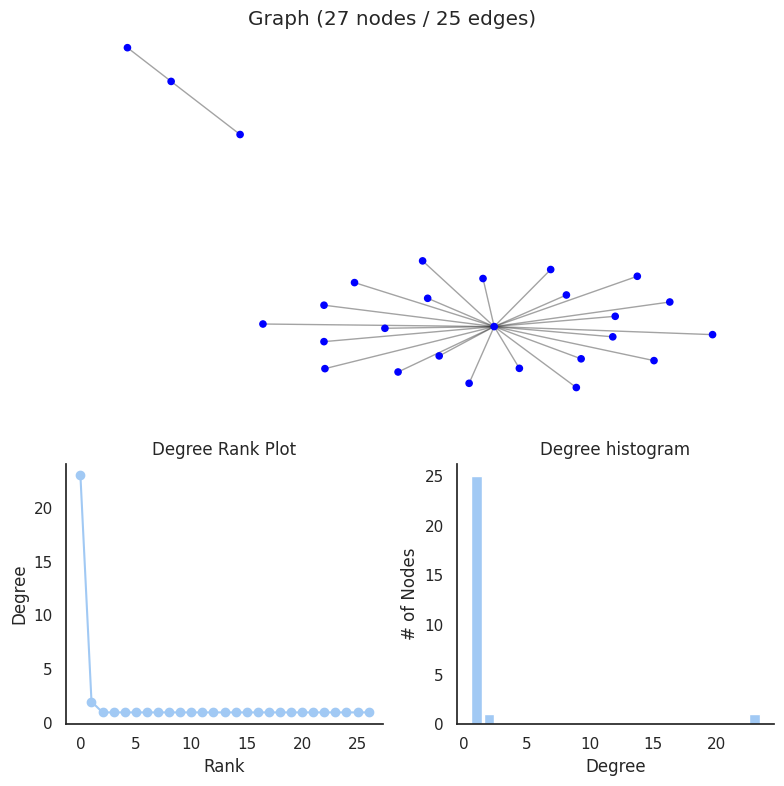

In [158]:
logger.info(print_cluster(c, go_database, 10, return_str=True))
plot_cluster(c, full_G, use_recipe=True)

---


## Export Differential Expression for Cytoscape

In [152]:
philharmonic_prots = set.union(
    *[set(c["members"]) for c in cluster_dict.values()]
).intersection(deg_df.index)
prot_deg_cytoscape_table_df = deg_df.loc[
    list(philharmonic_prots),
    [
        "log2FoldChange_Heat_control",
        "log2FoldChange_Antibiotics_control",
        "log2FoldChange_Antibiotics.Heat_control",
    ],
]

logger.info(f"Writing {len(philharmonic_prots)} entries to {prot_deg_cytoscape_table}")
prot_deg_cytoscape_table_df.to_csv(prot_deg_cytoscape_table, sep="\t")

2024-10-04 10:47:13.688 | INFO     | __main__:<module>:13 - Writing 4235 entries to /mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_proteins.deg.tsv


In [153]:
conditions = ["Heat_control", "Antibiotics_control", "Antibiotics.Heat_control"]
p_thresh = 0.05

cluster_de_df = []

for k, cl in tqdm(cluster_dict.items(), total=len(cluster_dict)):
    cluster_members = list(set(cl["members"]).intersection(deg_df.index))
    diffexp_df = deg_df.loc[cluster_members]
    cluster_row = [k]

    for cond in conditions:
        # log2FoldChange
        if len(diffexp_df):
            cluster_row.append(np.mean(diffexp_df[f"log2FoldChange_{cond}"]))
        else:
            cluster_row.append(np.nan)
        # padj
        cluster_row.append(np.sum(diffexp_df[f"padj_{cond}"] < p_thresh))
        # DE_Up
        cluster_row.append(np.sum(diffexp_df[f"DE_{cond}"] == "Upregulated"))
        # DE_Down
        cluster_row.append(np.sum(diffexp_df[f"DE_{cond}"] == "Downregulated"))
    cluster_de_df.append(cluster_row)

cluster_de_df = pd.DataFrame(cluster_de_df)
cluster_de_df.columns = ["key"] + [
    f"{j}_{i}"
    for i, j in product(conditions, ["log2FoldChange", "padj", "DE_Up", "DE_Down"])
]
cluster_de_df = cluster_de_df.set_index("key")

100%|██████████| 468/468 [00:01<00:00, 268.15it/s]


In [154]:
cluster_de_df.head()
cluster_de_df.to_csv(clust_deg_cytoscape_table, sep="\t")
logger.info(f"Writing {len(cluster_de_df)} entries to {clust_deg_cytoscape_table}")

2024-10-04 10:47:16.860 | INFO     | __main__:<module>:3 - Writing 468 entries to /mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.deg.tsv
